## Step 0: Install and Import Dependencies

In [13]:
import torch
from torch import nn

# Step 1: Get the Data

1.1. Download the Data from the Web (It will be a .zip file for this)

1.2. Extract the zip file

1.3. Delete the zip file


In [14]:
import requests
from pathlib import Path
import os
from zipfile import ZipFile

# Define the URL for the zip file
url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

# Send a GET request to download the file
response = requests.get(url)

# Define the path to the data directory
data_path = Path("data")

# Define the path to the image directory
image_path = data_path / "pizza_steak_sushi"

# Check if the image directory already exists
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Write the downloaded content to a zip file
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    f.write(response.content)

# Extract the contents of the zip file to the image directory
with ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zipref:
    zipref.extractall(image_path)

# Remove the downloaded zip file
os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory exists.


# Step 2: Define Transformations

1. Resize the images using `Resize()` to 224. We choose the images size to be 224 based on the ViT Paper

2. Convert to Tensor using `ToTensor()`

In [15]:
from torchvision.transforms import Resize, Compose, ToTensor

# Define the train_transform using Compose
train_transform = Compose([Resize((224, 224)), ToTensor()])

# Define the test_transform using Compose
test_transform = Compose([Resize((224, 224)), ToTensor()])

# Step 3: Create Dataset and DataLoader

We can use PyTorch's ImageFolder DataSet library to create our Datasets.

For ImageFolder to work this is how your data folder needs to be structured.

```markdown
data
└── pizza_steak_sushi
    ├── test
    │   ├── pizza
    │   ├── steak
    │   └── sushi
    └── train
        ├── pizza
        ├── steak
        └── sushi
```
All the `pizza` images will be in the pizza folder of train and test sub folders and so on for all the classes that you have.

There are two useful methods that you can call on the created `training_dataset` and `test_dataset`

1. `training_dataset.classes` that gives `['pizza', 'steak', 'sushi']`
2. `training_dataset.class_to_idx` that gives `{'pizza': 0, 'steak': 1, 'sushi': 2}`

In [16]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Define the data directory
data_dir = Path("data/pizza_steak_sushi")

# Create the training dataset using ImageFolder
training_dataset = ImageFolder(root=data_dir / "train", transform=train_transform)

# Create the test dataset using ImageFolder
test_dataset = ImageFolder(root=data_dir / "test", transform=test_transform)

# Create the training dataloader using DataLoader
training_dataloader = DataLoader(
    dataset=training_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=2
)

# Create the test dataloader using DataLoader
test_dataloader = DataLoader(
    dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=2
)

We can visualize a few training dataset images and see their labels

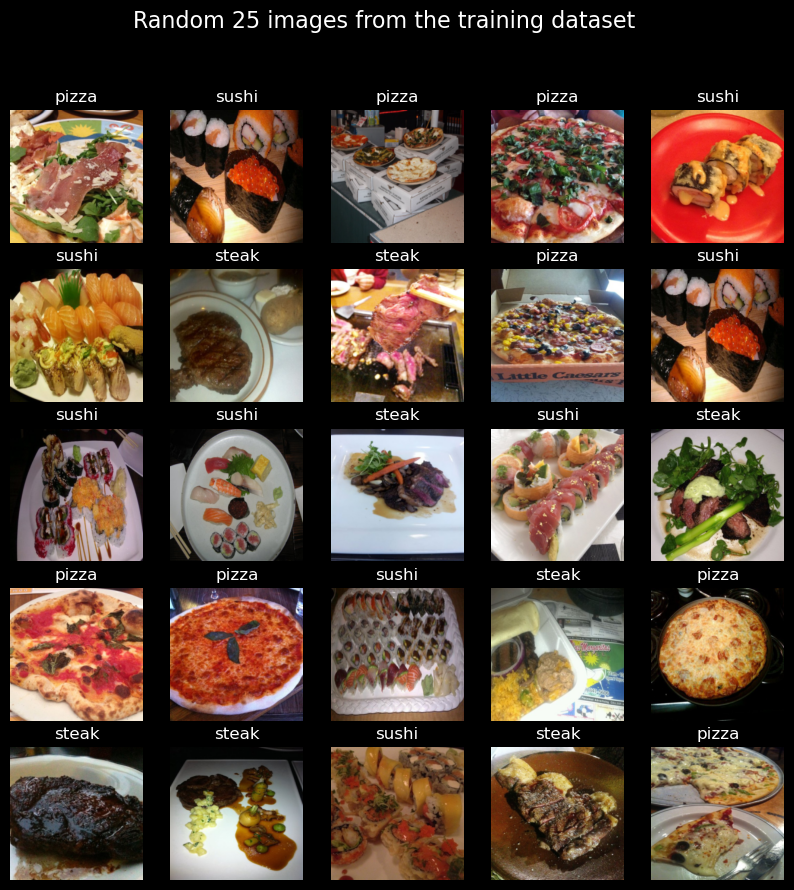

In [17]:
import matplotlib.pyplot as plt
import random

num_rows = 5
num_cols = num_rows

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Iterate over the subplots and display random images from the training dataset
for i in range(num_rows):
    for j in range(num_cols):
        # Choose a random index from the training dataset
        image_index = random.randrange(len(training_dataset))

        # Display the image in the subplot
        axs[i, j].imshow(training_dataset[image_index][0].permute((1, 2, 0)))

        # Set the title of the subplot as the corresponding class name
        axs[i, j].set_title(
            training_dataset.classes[training_dataset[image_index][1]], color="white"
        )

        # Disable the axis for better visualization
        axs[i, j].axis(False)

# Set the super title of the figure
fig.suptitle(
    f"Random {num_rows * num_cols} images from the training dataset",
    fontsize=16,
    color="white",
)

# Set the background color of the figure as black
fig.set_facecolor(color="black")

# Display the plot
plt.show()

# Understanding Vision Transformer

Let us take some time now to understand the Vision Transformer Architecture. This is the link to the original vision transformer paper: https://arxiv.org/abs/2010.11929.

Below you can see the architecture that is proposed in the image.

<img height = "430" src = "https://res.cloudinary.com/dltwftrgc/image/upload/v1686823579/Blogs/Vision-Transformer/Vision_Transformer_Architecture_woi9aw.png">

The Vision Transformer (ViT) is a type of Transformer architecture designed for image processing tasks. Unlike traditional Transformers that operate on sequences of word embeddings, ViT operates on sequences of image embeddings. In other words, it breaks down an input image into patches and treats them as a sequence of learnable embeddings.

At a broad level, what ViT does is, it:

1. **Creates Patch Emebeddings**
     1. Takes an input image of a given size $(H \times W \times C)$ -> (Height, Width, Channels)
     2. Breaks it down into $N$ patches of a given size: $P$ --> PATCH_SIZE
     3. Converts the patches into a **sequence** of learnable embeddings vectors: $E ∈ R^{(P^2C) \times D}$
     4. Prepends a **classification token embedding vector** to the learnable embeddings vectors
     5. Adds the **position embeddings** to the learnable embeddings: $E_{pos} \in R^{(N+1) \times D}$
   
2. Passes embeddings through **Transformer Blocks**:

     - The patch embeddings, along with the classification token, are passed through multiple Transformer blocks.
     - Each Transformer block consists of a MultiHead Self-Attention Block (MSA Block) and a Multi-Layer Perceptron Block (MLP Block).
     - Skip connections are established between the input to the Transformer block and the input to the MSA block, as well as between the input to the MLP block and the output of the MLP block. These skip connections help mitigate the vanishing gradient problem as more Transformer blocks are added.
  
3. Performs **Classification**:

     - The final output from the Transformer blocks is passed through an MLP block.
     - The classification token, which contains information about the input image's class, is used to make predictions.


We will dive into each of these steps in detail, starting with the crucial process of creating patch embeddings.

---


# Step 4: Create Patch Embedding Layer

For the ViT paper we need to perform the following functions on the image before passing to the MultiHead Self Attention Transformer Layer

1. Convert the image into patches of 16 x 16 size.
2. Embed each patch into 768 dimensions. So each patch becomes a `[1 x 768] ` Vector. There will be $N = \frac{H \times W}{P^2}$ number of patches for each image. This results in an image that is of the shape `[14 x 14 x 768]`
3.  Flatten the image along a single vector. This will give a `[196 x 768]` Matrix which is our Image Embedding Sequence.
4. Prepend the Class Token Embeddings to the above output
5. Add the Position Embeddings to the Class Token and Image Embeddings.




![Vision Tranformer Steps](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/08-vit-paper-patch-embedding-animation.gif)

In [18]:
PATCH_SIZE = 16
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 3
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2)

# the image width and image height should be divisible by patch size. This is a check to see that.

assert IMAGE_WIDTH % PATCH_SIZE == 0 and IMAGE_HEIGHT % PATCH_SIZE == 0, print(
    "Image Width is not divisible by patch size"
)

## Step 4.1 Converting the image into patches of 16 x 16 and creating an embedding vector for each patch of size 768.

This can be accomplished by using a Conv2D Layer with a kernel_size equal to patch_size and a stride equal to patch_size

<img src = "https://res.cloudinary.com/dltwftrgc/image/upload/v1686832476/Blogs/Vision-Transformer/CNN_Flatten_vfq1q6.png" width = "600">
<!-- ![Convolution plus Flatten](https://res.cloudinary.com/dltwftrgc/image/upload/v1686832476/Blogs/Vision-Transformer/CNN_Flatten_vfq1q6.png) -->



In [19]:
conv_layer = nn.Conv2d(in_channels=IMAGE_CHANNELS,
                       out_channels=EMBEDDING_DIMS, kernel_size=PATCH_SIZE, stride=PATCH_SIZE)

We can pass a random image into the convolutional layer and see what happens

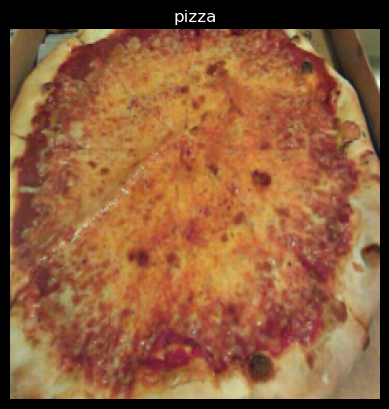

In [20]:
random_images, random_labels = next(iter(training_dataloader))
random_image = random_images[0]

# Create a new figure
fig = plt.figure(1)

# Display the random image
plt.imshow(random_image.permute((1, 2, 0)))

# Disable the axis for better visualization
plt.axis(False)

# Set the title of the image
plt.title(training_dataset.classes[random_labels[0]], color="white")

# Set the background color of the figure as black
fig.set_facecolor(color="black")

We need to change the shape to `[1, 14, 14, 768]` and flatten the output to `[1, 196, 768]`

In [21]:
# Pass the image through the convolution layer
image_through_conv = conv_layer(random_image.unsqueeze(0))
print(
    f"Shape of embeddings through the conv layer -> {list(image_through_conv.shape)} <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]"
)

# Permute the dimensions of image_through_conv to match the expected shape
image_through_conv = image_through_conv.permute((0, 2, 3, 1))

# Create a flatten layer using nn.Flatten
flatten_layer = nn.Flatten(start_dim=1, end_dim=2)

# Pass the image_through_conv through the flatten layer
image_through_conv_and_flatten = flatten_layer(image_through_conv)

# Print the shape of the embedded image
print(
    f"Shape of embeddings through the flatten layer -> {list(image_through_conv_and_flatten.shape)} <- [batch_size, num_of_patches, embedding_dims]"
)

# Assign the embedded image to a variable
embedded_image = image_through_conv_and_flatten

Shape of embeddings through the conv layer -> [1, 768, 14, 14] <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]
Shape of embeddings through the flatten layer -> [1, 196, 768] <- [batch_size, num_of_patches, embedding_dims]


## 4.2. Prepending the Class Token Embedding and Adding the Position Embeddings

In [22]:
class_token_embeddings = nn.Parameter(
    torch.rand((1, 1, EMBEDDING_DIMS), requires_grad=True)
)
print(
    f"Shape of class_token_embeddings --> {list(class_token_embeddings.shape)} <-- [batch_size, 1, emdedding_dims]"
)

embedded_image_with_class_token_embeddings = torch.cat(
    (class_token_embeddings, embedded_image), dim=1
)
print(
    f"\nShape of image embeddings with class_token_embeddings --> {list(embedded_image_with_class_token_embeddings.shape)} <-- [batch_size, num_of_patches+1, embeddiing_dims]"
)

position_embeddings = nn.Parameter(
    torch.rand((1, NUM_OF_PATCHES + 1, EMBEDDING_DIMS), requires_grad=True)
)
print(
    f"\nShape of position_embeddings --> {list(position_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]"
)

final_embeddings = embedded_image_with_class_token_embeddings + position_embeddings
print(
    f"\nShape of final_embeddings --> {list(final_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]"
)

Shape of class_token_embeddings --> [1, 1, 768] <-- [batch_size, 1, emdedding_dims]

Shape of image embeddings with class_token_embeddings --> [1, 197, 768] <-- [batch_size, num_of_patches+1, embeddiing_dims]

Shape of position_embeddings --> [1, 197, 768] <-- [batch_size, num_patches+1, embeddings_dims]

Shape of final_embeddings --> [1, 197, 768] <-- [batch_size, num_patches+1, embeddings_dims]


Shape of `class_token_embeddings` --> `[1, 1, 768]` <-- `[batch_size, 1, emdedding_dims]`

Shape of `image embeddings with class_token_embeddings` --> `[1, 197, 768]` <-- `[batch_size, num_of_patches+1, embeddiing_dims]`

Shape of `position_embeddings` --> `[1, 197, 768]` <-- `[batch_size, num_patches+1, embeddings_dims]`

Shape of `final_embeddings` --> `[1, 197, 768]` <-- `[batch_size, num_patches+1, embeddings_dims]`

## Put the PatchEmbedddingLayer Together

We will inherit from the PyTorch `nn.Module` to create our custom layer which takes in an image and throws out the patch embeddings which consists of the Image Embeddings, Class Token Embeddings and the Position Embeddings.

In [23]:
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
        self.conv_layer = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
        self.class_token_embeddings = nn.Parameter(
            torch.rand((BATCH_SIZE, 1, EMBEDDING_DIMS), requires_grad=True)
        )
        self.position_embeddings = nn.Parameter(
            torch.rand((1, NUM_OF_PATCHES + 1, EMBEDDING_DIMS), requires_grad=True)
        )

    def forward(self, x):
        output = (
            torch.cat(
                (
                    self.class_token_embeddings,
                    self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1))),
                ),
                dim=1,
            )
            + self.position_embeddings
        )
        return output

In [24]:
patch_embedding_layer = PatchEmbeddingLayer(
    in_channels=IMAGE_CHANNELS,
    patch_size=PATCH_SIZE,
    embedding_dim=IMAGE_CHANNELS * PATCH_SIZE**2,
)

patch_embeddings = patch_embedding_layer(random_images)
patch_embeddings.shape

torch.Size([32, 197, 768])